PyTorch version: 2.8.0
MPS available: True
MPS built: True
0.23.0
Using Metal Performance Shaders (macOS)
Device: mps
Epoch 1/10, Train Loss: 0.7017, Val Loss: 0.6850
Epoch 2/10, Train Loss: 0.6570, Val Loss: 0.6575
Epoch 3/10, Train Loss: 0.5885, Val Loss: 0.6716
Epoch 4/10, Train Loss: 0.5360, Val Loss: 0.8216
Epoch 5/10, Train Loss: 0.4817, Val Loss: 0.6475
Epoch 6/10, Train Loss: 0.3885, Val Loss: 0.6472
Epoch 7/10, Train Loss: 0.2950, Val Loss: 0.7744
Epoch 8/10, Train Loss: 0.1974, Val Loss: 0.7792
Epoch 9/10, Train Loss: 0.1390, Val Loss: 1.0754
Epoch 10/10, Train Loss: 0.0722, Val Loss: 1.0518


/Volumes/Nvme_1/Desktop/github/NeuralNetwork01/.venv/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))



Test Accuracy: 63.07%


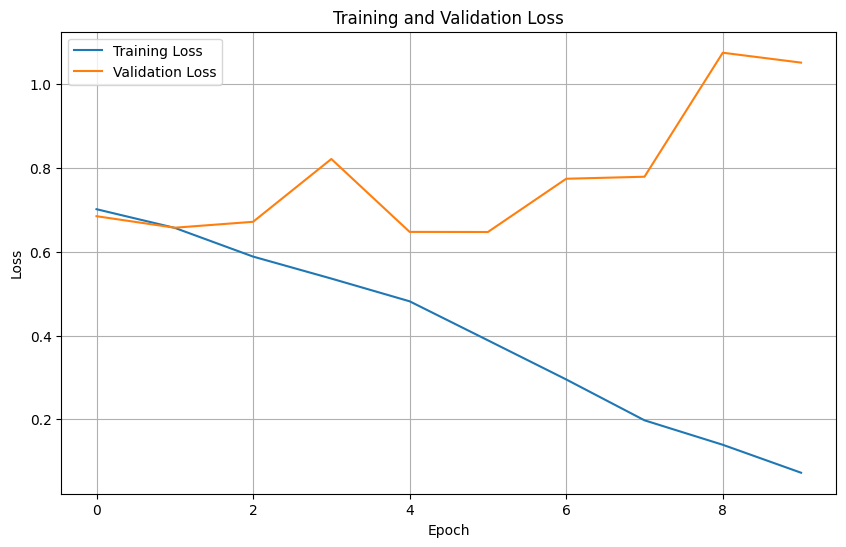

In [1]:
# cat_detection.ipynb
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")
print(torchvision.__version__)  # Should print 0.18.1

# Test device
 # Check all available backends
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Metal Performance Shaders (macOS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Fixed CatDataset class
class CatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Valid image extensions
        valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}

        # Load images from subdirectories
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)

            # Skip if not a directory or if it's a checkpoint directory
            if not os.path.isdir(class_path) or class_name.startswith('.'):
                continue

            label = 1 if class_name == 'cat' else 0

            for filename in os.listdir(class_path):
                # Skip hidden files, directories, and non-image files
                if (filename.startswith('.') or
                    os.path.isdir(os.path.join(class_path, filename)) or
                    not any(filename.lower().endswith(ext) for ext in valid_extensions)):
                    continue

                img_path = os.path.join(class_path, filename)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load datasets
train_dataset = CatDataset('images/train', transform=transform)
val_dataset = CatDataset('images/val', transform=transform)
test_dataset = CatDataset('images/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define CNN
class CatCNN(nn.Module):
    def __init__(self):
        super(CatCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # 2 classes: cat, non_cat
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Initialize model, loss, optimizer
model = CatCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"\nTest Accuracy: {accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()